<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function

try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')

get_ipython().magic(u'matplotlib qt')
import numpy as np
import matplotlib.pyplot as plt
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid, motion_correct_oneP_nonrigid
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl
bpl.output_notebook()

Loading BokehJS ...

### Setup some parameters
few of them (that typically shouldn't be changed for 1p data) will be set directly calling the CNMF object

In [2]:
# dataset dependent parameters
fnames = ['data_endoscope.tif']  # filename to be processed
frate = 10                       # movie frame rate
decay_time = 0.1                 # length of a typical transient in seconds

In [3]:
# motion correction parameters
do_motion_correction_nonrigid = True
do_motion_correction_rigid = False  # in this case it will also save a rigid motion corrected movie
gSig_filt = (4, 4)       # size of filter, in general gSig (see below),
#                          change this one if algorithm does not work
max_shifts = (5, 5)      # maximum allowed rigid shift
splits_rig = 10          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
splits_els = 10          # for parallelization split the movies in  num_splits chuncks across time
#                          (remember that it should hold that length_movie/num_splits_to_process_rig>100)
upsample_factor_grid = 4 # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts

In [4]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = 3            # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 13           # average diameter of a neuron, in general 4*gSig+1
merge_thresh = .7   # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
Ain = None          # if you want to initialize with some preselected components
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                             True performs global low-rank approximation 
gnb = -1            # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb=-2: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb= 0: Don't return background
nb_patch = -1       # number of background components (rank) per patch,
#                     use 0 or -1 for exact background of ring model (cf. gnb)
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

In [5]:
# parameters for component evaluation
min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.85    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)

Download the dataset if not already present

In [6]:
fnames = ['/home/sebastian/Desktop/32364_trial_20170710_120637-cropped.tif']#[download_demo(fnames[0])]

### (Re)start cluster.  

In [8]:
import psutil

# stop the cluster if one exists
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")

using 16 processes
Stopping  cluster to avoid unnencessary use of memory....


In [9]:
try:
    cm.stop_server(dview=dview) # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=n_processes,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

(2800, 81, 81)
(2800, 81, 81)
using 1 processes
using 1 processes
(2800, 81, 81)
using 1600 pixels per process
using 1600 pixels per process
(2800, 81, 81)
using 5000 block_size
preprocessing ...
using 5000 block_size
using 1 processes
using 1 processes
(2800, 81, 81)
using 1600 pixels per process
preprocessing ...
using 5000 block_size
preprocessing ...
using 1 processes
checking if missing data
checking if missing data
(2800, 81, 81)
checking if missing data
using 1600 pixels per process
using 5000 block_size
preprocessing ...
using 1 processes
using 1600 pixels per process
(2800, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
using 5000 block_size
checking if missing data
(2800, 81, 81)
preprocessing ...
using 1600 pixels per process
preprocessing ...
checking if missing data
using 5000 block_size
using 1 processes
checking if missing data
preprocessing ...
using 1600 pixels per process
using 5000 block_size
checking if missing data
preprocessing ...
c

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 9.82856798171997 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 23.647331714630127 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 11 temporal components updated
5 out of total 11 temporal components updated
9 out of total 11 temporal components updated
11 out of total 11 temporal components updated
3 out of total 11 temporal components updated
5 out of total 11 temporal components updated
9 out of total 11 temporal components updated
11 out of total 11 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residu

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Compute Background
Update Spatial
In total,  0 neurons were initialized.
Initializing update of Spatial Components
computing the distance indicators
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 9.081718444824219 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 8.036675930023193 seconds ---
Removing tempfiles created
thresholding components
Update Temporal
Computing residuals
thresholding components
Generating residuals
Computing residuals
--- 8.874868869781494 seconds ---
--- 8.7356538772583 seconds ---
Removing tempfiles created
Removing tempfiles created
Update Temporal
Update Temporal


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Generating residuals
entering the deconvolution 
Generating residuals
stopping: overall temporal component not changing significantly
Initialization again


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
In total,  0 neurons were initialized.
--- 3.3392276763916016 seconds ---
Removing tempfiles created
Merge Components
Update Temporal
No neurons merged!
Generating residuals
memmaping
Update Spatial
entering the deconvolution 
stopping: overall temporal component not changing significantly
Updating Spatial Components using lasso lars
Com

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 16.089723348617554 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 20.651477336883545 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


thresholding components
Computing residuals
--- 20.26732897758484 seconds ---
Update Spatial
Removing tempfiles created
Initializing update of Spatial Components
computing the distance indicators
Update Temporal
Generating residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 15.331176280975342 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 28.34446930885315 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 26.68973708152771 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
In total,  0 neurons were initialized.
memmaping
Merge Components
Updating Spatial Components using lasso lars
No neurons merged!
Update Spatial
Initializing update of Spatial Components
entering the deconvolution 
computing the distance indicators
3 out of total 7 temporal components updated
6 out of total 7 temporal components updated
7 out of total 7 temporal components updated
3 out of total 7 temporal components updated
6 out of total 7 temporal components updated
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 12.826293706893921 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 11.764126777648926 seconds ---
In total,  0 neurons were initialized.
Removing tempfiles created
Merge Components
No neurons merged!
Update Temporal
Update Spatial
Generating residuals
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
thresholding components
Computing residuals
--- 16.275420427322388 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thres

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 21.325761318206787 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 14.210994482040405 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
Update Temporal
stopping: overall temporal component not changing significantly
Initialization again
Generating residuals
entering the deconvolution 
3 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
3 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 33.92314553260803 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute 

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 12.043171405792236 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 6.8795037269592285 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
entering the deconvolution 
Computing residuals
--- 10.790862321853638 seconds ---
stopping: overall temporal component not changing significantly
Initialization again
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 35.46367883682251 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
thresholding components
Computing residuals
--- 11.107794046401978 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 5 temporal components updated
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
2 out of total 5 

Spatial Downsampling 1-photon
memmaping
Updating Spatial Components using lasso lars
Roi Extraction...
One photon initialization..
thresholding components
initializing ...
Computing residuals
--- 6.769087791442871 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
entering the deconvolution 
stopping: overall temporal component not changing significantly
Return full Background
True
Roi Extraction...
One photon initialization..
thresholding components
Computing residuals
--- 23.455626964569092 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
0 neurons have been initialized
3 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
3 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components upd

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 52.37620425224304 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
[0 3]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 46.670591831207275 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
3 out of total 4 temporal components upda

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 7.353448390960693 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 10.102624654769897 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
[0 1]
Update Spatial
Initializing update of Spatial C

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 6.144671678543091 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


thresholding components
Computing residuals
--- 39.51069617271423 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
(2800, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
initializing ...
Spatial Downsampling 1-photon
thresholding components
Computing residuals
--- 24.943939447402954 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Roi Extraction...
One photon initialization..
In total,  0 neurons were 

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


thresholding components
Computing residuals
--- 42.80912446975708 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 20.257548093795776 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spa

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 33.52469515800476 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 18.587769985198975 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating 

### Creation of a memory mappable file. 
    - Performs motion correction and simultaneously creates a memory mappable file in F order
    - Transforms into C order (much more efficient for parallel processing
    - If you have multiple files there are ways to process many at the same time (not shown)
    

Rigid Motion Correction
5.45665
-0.567331673503


/home/sebastian/Documents/CaImAn/caiman/base/movies.py:270: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:289: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.567331673503
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.567331673503
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 5.45665
0
saving!
** Starting parallel motion correction **
** Finished parallel motion correction **
0.214411
Adding to movie 1.1508
0
saving mmap of /home/sebastian/Desktop/32364_trial_20170710_120637-cropped.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
** Starting parallel motion correction **
** Finished parallel motion correction **
Adding to movie 1.1508
0
saving mmap of /home/sebastian/Desktop/32364_trial_20170710_120637-cropped.tif
** Starting parallel motion correction **
** Finished parallel motion correction **


  0%|          | 0/1 [00:00<?, ?it/s]

loading in memory


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

mmap


SAVING WITH numpy.tofile()


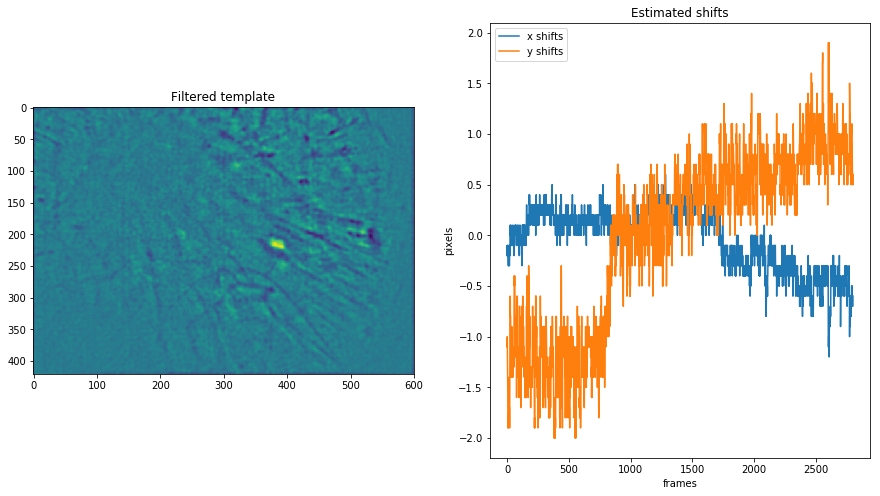

In [21]:
%matplotlib inline
if do_motion_correction_nonrigid or do_motion_correction_rigid:
    # do motion correction rigid
    mc = motion_correct_oneP_rigid(fnames,
                                   gSig_filt=gSig_filt,
                                   max_shifts=max_shifts,
                                   dview=dview,
                                   splits_rig=splits_rig,
                                   save_movie=not(do_motion_correction_nonrigid)
                                   )

    new_templ = mc.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)     #borders to eliminate from movie because of motion correction        

    # do motion correction nonrigid
    if do_motion_correction_nonrigid:
        mc = motion_correct_oneP_nonrigid(
            fnames,
            gSig_filt=gSig_filt,
            max_shifts=max_shifts,
            strides=strides,
            overlaps=overlaps,
            splits_els=splits_els,
            upsample_factor_grid=upsample_factor_grid,
            max_deviation_rigid=max_deviation_rigid,
            dview=dview,
            splits_rig=None,
            save_movie=True,  # whether to save movie in memory mapped format
            new_templ=new_templ  # template to initialize motion correction
        )

        bord_px = np.ceil(
            np.maximum(np.max(np.abs(mc.x_shifts_els)),
                       np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

    # create memory mappable file in the right order on the hard drive (C order)        
        fname_new = cm.save_memmap([mc.fname_tot_els], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
    else:
        fname_new = cm.save_memmap([mc.fname_tot_rig], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
else:
    fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [10]:
# load memory mappable file
Yr, dims, T = cm.load_memmap('/home/sebastian/Desktop/32364_20170710_els_d1_420_d2_600_d3_1_order_C_frames_2800_.mmap')
Y = Yr.T.reshape((T,) + dims, order='F')

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel. **BEWARE** the movie may appear in the background!

In [10]:
m_orig = cm.movie(Y)
downsample_ratio = 1.
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(gain=2, offset=offset_mov, fr=30, magnification=1)

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

In [11]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter, pnr)

/home/sebastian/Documents/CaImAn/caiman/summary_images.py:348: RuntimeWarning: invalid value encountered in less
  pnr[pnr < 0] = 0
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:352: RuntimeWarning: invalid value encountered in less
  tmp_data[tmp_data < 3] = 0


In [12]:
# print parameters set above, modify them if necessary based on summary images
print(min_corr) # min correlation of peak (from correlation image)
print(min_pnr)  # min peak to noise ratio

0.8
10


In [14]:
bord_px=0

### Set CNMF parameters and run it

In [ ]:
cnm = cnmf.CNMF(n_processes=n_processes,
                method_init='corr_pnr',             # use this for 1 photon
                k=K,
                gSig=(gSig, gSig),
                gSiz=(gSiz, gSiz),
                merge_thresh=merge_thresh,
                p=p,
                dview=dview,
                tsub=tsub,
                ssub=ssub,
                Ain=Ain,
                rf=rf,
                stride=stride_cnmf,
                only_init_patch=True,               # just leave it as is
                gnb=gnb,
                nb_patch=nb_patch,
                method_deconvolution='oasis',       # could use 'cvxpy' alternatively
                low_rank_background=low_rank_background,
                update_background_components=True,  # sometimes setting to False improve the results
                min_corr=min_corr,
                min_pnr=min_pnr,
                normalize_init=False,               # just leave as is
                center_psf=True,                    # leave as is for 1 photon
                ssub_B=ssub_B,
                ring_size_factor=ring_size_factor,
                del_duplicates=True,                # whether to remove duplicates from initialization
                border_pix=bord_px)                 # number of pixels to not consider in the borders
cnm.fit(Y)

(2800, 420, 600)
using 16 processes
using 4000 pixels per process
using 5000 block_size
(80, 80)


In [28]:
print(cnm.A)

None


plot contours of identified components against correlation image

/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:953: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


ValueError: dimension mismatch

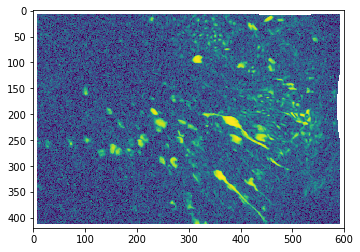

In [26]:
crd = cm.utils.visualization.plot_contours(cnm.A, cn_filter, thr=.8, vmax=0.99)

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y, cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, frate, 
                            decay_time, gSig, dims, dview=dview, 
                            min_SNR=min_SNR, r_values_min=r_values_min, use_cnn=False)

print(' ***** ')
print((len(cnm.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

Plot contours of selected and rejected components

In [ ]:
#%% PLOT COMPONENTS

plt.figure(figsize=(15,8));
plt.subplot(121);
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of accepted components')
plt.subplot(122); 
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components_bad], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of rejected components');

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

In [ ]:
# rejected components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

### Stop cluster

In [ ]:
cm.stop_server(dview=dview)

### Some instructive movies

In [ ]:
B = cnm.b.dot(cnm.f)
if 'sparse' in str(type(B)):
    B = B.toarray()

In [ ]:
#%% denoised movie
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.)

In [ ]:
#%% only neurons
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components]),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 10.)

In [ ]:
#%% only the background
cm.movie(np.reshape(B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.)

In [ ]:
#%% residuals
cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 10., fr = 10)


In [ ]:
#%% eventually, you can rerun the algorithm on the residuals
plt.imshow(cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).local_correlations(swap_dim=False))